## Modulo designado para la creación de el modelo de Random Forest
En este punto los datasets ya se encuentran en archivos .csv dentro de la carpeta
"CSV ready to model"


In [1]:
import pandas as pd
from scikitplot.metrics import plot_roc, plot_roc_curve
from sklearn.preprocessing import LabelEncoder
import numpy as np
import scikitplot as skplt#Esta librería toca instalarla "conda install -c conda-forge scikit-plot"
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
df=pd.read_csv('../../CSV ready to model/withoutPCA.csv')

Label encoder para la columna a predecir

In [2]:
df['GRAVEDAD'].value_counts()

HERIDO        60201
SOLO DAÑOS    52790
MUERTO          668
Name: GRAVEDAD, dtype: int64

In [3]:
le=LabelEncoder()
df['GRAVEDAD']=df.loc[:,['GRAVEDAD']].apply(le.fit_transform)

In [4]:
train,test = [x for _, x in df.groupby(df['PERIODO'] > 2018)]

In [5]:
train=train.drop(['PERIODO'],axis=1)
test=test.drop(['PERIODO'],axis=1)
y_train = train['GRAVEDAD'].values
x_train = (train.drop(['GRAVEDAD'], axis = 1)).values
y_test = test['GRAVEDAD'].values
x_test=(test.drop(['GRAVEDAD'],axis=1)).values


In [6]:

def classification_error(y_est, y_real):
    err = 0
    for y_e, y_r in zip(y_est, y_real):

        if y_e != y_r:
            err += 1

    return err/np.size(y_est)


In [7]:
def model_RF(x,y,estimadores, caracteristicas, impresion = False):

    tiempo_i = time.time()
    accuracy_list = np.zeros([4])
    precision_list = np.zeros([4,3])
    recall_list = np.zeros([4,3])
    f_list = np.zeros([4,3])
    errores = np.zeros(4)

    RF = RandomForestClassifier(n_estimators=estimadores, max_features =caracteristicas, n_jobs = -1)
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(x, y, test_size=0.25) # Modificar metodología de validación

        RF.fit(Xtrain, Ytrain)
        pred = RF.predict(Xtest)

        #code for calculating accuracy
        _accuracy_ = accuracy_score(Ytest, pred, normalize=True)
        accuracy_list[j] = _accuracy_

        #code for calculating recall
        _recalls_ = recall_score(Ytest, pred, average=None)
        recall_list[j] = _recalls_

        #code for calculating precision
        _precisions_ = precision_score(Ytest, pred, average=None)
        precision_list[j] = _precisions_

        _f_score_ = f1_score(Ytest, pred, average=None)
        f_list[j] = _f_score_


        errores[j] = classification_error(pred, Ytest)


    if impresion == True:
        #Curva ROC

        rf_probs = RF.predict_proba(Xtest)
        print(rf_probs)
        plot_roc(Xtest, Ytest, rf_probs, "Random Forest")
        auc = roc_auc_score(Ytest, pred)
        print('AUC: %.2f' % auc)
        fpr, tpr, thresholds = roc_curve(Ytest, pred)
        plot_roc_curve(fpr, tpr)
        #Matriz de confusión
        skplt.metrics.plot_confusion_matrix(Ytest, pred, normalize=True)

    result={'Eficiencia':np.mean(accuracy_list),'Int_Eficiencia':np.std(accuracy_list),
        'Sensibilidad':np.mean(recall_list),'Int_Sensibilidad':np.std(recall_list),
        'Precisión':np.mean(precision_list),'Int Precisión':np.std(precision_list),
        'F':np.mean(f_list),'Int_F':np.std(f_list),
        'Error':np.mean(errores),'Int_Error':np.std(errores),
        'Tiempo':time.time()-tiempo_i
        }
    return  result


Otra prueba con train test split, o sea que los datos no se dividen por periodos

In [8]:
otherDF=df.drop(['PERIODO'],axis=1)

In [9]:
y=otherDF['GRAVEDAD']
x=otherDF.drop(['GRAVEDAD'],axis=1)


In [10]:
result= model_RF(x=x,y=y,estimadores=100,caracteristicas= 9, impresion = False)

In [45]:
model = RandomForestClassifier(n_estimators=1, max_features =9, n_jobs = -1)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x, y, test_size=0.2) # Modificar metodología de validación
model.fit(Xtrain, Ytrain)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

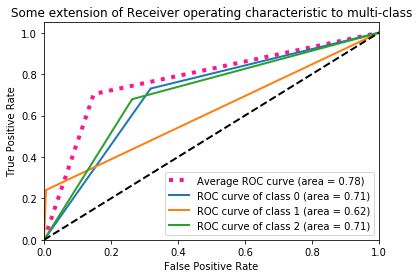

In [46]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_predict_proba = model.predict_proba(Xtest)


# Compute ROC curve and ROC AUC for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
all_y_test_i = np.array([])
all_y_predict_proba = np.array([])
for i in range(n_classes):
    y_test_i = list(map(lambda x: 1 if x == i else 0, Ytest))
    all_y_test_i = np.concatenate([all_y_test_i, y_test_i])
    all_y_predict_proba = np.concatenate([all_y_predict_proba, y_predict_proba[:, i]])
    fpr[i], tpr[i], _ = roc_curve(y_test_i, y_predict_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["average"], tpr["average"], _ = roc_curve(all_y_test_i, all_y_predict_proba)
roc_auc["average"] = auc(fpr["average"], tpr["average"])

# Plot average ROC Curve
plt.figure()
plt.plot(fpr["average"], tpr["average"],
         label='Average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["average"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot each individual ROC curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [47]:
roc_auc["average"] 

0.7778308981782819

In [48]:
auc(fpr["average"], tpr["average"])

0.7778308981782819

In [44]:
all_y_test_i

array([1., 0., 1., ..., 1., 0., 1.])

In [43]:
len(all_y_predict_proba)

68196

In [ ]:
import qgrid #Este paquete toca instalarlo o f
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
randn = np.random.randn
df_types = pd.DataFrame({
    'Numero de arboles' : pd.Series([5,5,5,5,5,
                                     10,10,10,10,10,
                                     20,20,20,20,20,
                                     50,50,50,50,50,
                                     100,100,100,100,100]),
    'Variables analizadas por nodo' : pd.Series([5,6,7,8,9,
                                                 5,6,7,8,9,
                                                 5,6,7,8,9,
                                                 5,6,7,8,9,
                                                 5,6,7,8,9])})
df_types["Eficiencia"] = ""
df_types["Int_Eficiencia"] = ""
df_types["Sensibilidad"] = ""
df_types["Int_Sensibilidad"] = ""
df_types["Precision"] = ""
df_types["Int_Precision"] = ""
df_types["F-Score"] = ""
df_types["Int_F-Score"] = ""

df_types["Error_Prueba"] = ""
df_types["Int_error"] = ""
df_types["Tiempo de ejecución"] = ""
df_types.set_index(['Numero de arboles','Variables analizadas por nodo'], inplace=True)

for n, k in df_types.index:
    result = model_RF(x,y,n, k, impresion = False)
    df_types["Eficiencia"][n,k] = result['Eficiencia']
    df_types["Int_Eficiencia"][n,k] = result['Int_Eficiencia']
    df_types["Sensibilidad"][n,k] = result['Sensibilidad']
    df_types["Int_Sensibilidad"][n,k] = result['Int_Sensibilidad']
    df_types["Precision"][n,k] = result['Precisión']
    df_types["Int_Precision"][n,k] = result['Precisión']
    df_types["F-Score"][n,k] = result['F']
    df_types["Int_F-Score"][n,k] = result['Int_F']
    df_types["Error_Prueba"][n,k] = result['Error']
    df_types["Int_error"][n,k] = result['Int_Error']
    df_types["Tiempo de ejecución"][n,k] = result['Tiempo']

#df_types.sort_index(inplace=True)
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget